# Baseline model for batch monitoring example

In [2]:
import datetime
import pandas as pd

from evidently.report import Report
from evidently import ColumnMapping
from evidently.metrics import DatasetMissingValuesMetric, DatasetDriftMetric, ColumnDriftMetric

from joblib import dump, load

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

/opt/homebrew/Caskroom/miniconda/base/envs/venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniconda/base/envs/venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniconda/base/envs/ven

In [3]:
jan_data = pd.read_parquet('data/green_tripdata_2022-01.parquet')

In [4]:
jan_data.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,62495.000000,62495,62495,56200.000000,62495.000000,62495.000000,56200.000000,62495.000000,62495.000000,62495.00000,62495.000000,62495.000000,62495.000000,62495.000000,62495.000000,56200.000000,56200.000000,56200.000000
mean,1.849508,2022-01-16 14:18:36.026353920,2022-01-16 14:37:37.189551104,1.198719,97.615041,135.969902,1.258399,77.758632,13.914000,0.34756,0.426322,1.666540,0.208182,0.297312,17.490532,1.403594,1.040925,0.706628
min,1.000000,2009-01-01 00:34:01,2009-01-01 17:05:20,1.000000,1.000000,1.000000,0.000000,0.000000,-65.000000,-4.50000,-0.500000,-0.860000,-6.550000,-0.300000,-71.850000,1.000000,1.000000,0.000000
25%,2.000000,2022-01-08 23:41:50,2022-01-08 23:55:28.500000,1.000000,55.000000,74.000000,1.000000,1.080000,7.000000,0.00000,0.500000,0.000000,0.000000,0.300000,9.360000,1.000000,1.000000,0.000000
50%,2.000000,2022-01-16 15:59:42,2022-01-16 16:17:00,1.000000,75.000000,137.000000,1.000000,1.900000,10.500000,0.00000,0.500000,1.000000,0.000000,0.300000,13.860000,1.000000,1.000000,0.000000
75%,2.000000,2022-01-24 09:16:50,2022-01-24 09:37:28,1.000000,130.000000,215.000000,1.000000,3.500000,17.000000,0.50000,0.500000,2.610000,0.000000,0.300000,21.050000,2.000000,1.000000,2.750000
max,2.000000,2022-01-31 23:57:37,2022-02-01 21:01:54,5.000000,265.000000,265.000000,8.000000,224481.380000,604.500000,4.50000,0.500000,76.770000,44.750000,0.300000,605.300000,5.000000,2.000000,2.750000
std,0.357556,NaN,NaN,0.862313,62.987311,77.590956,0.877743,2909.354163,12.088819,0.65781,0.181381,2.484928,1.257659,0.037201,13.623416,0.516316,0.198119,1.201632


In [5]:
jan_data.shape

(62495, 20)

In [6]:
#target generation
jan_data['duration_min'] = jan_data.lpep_dropoff_datetime - jan_data.lpep_pickup_datetime
jan_data.duration_min = jan_data.duration_min.apply(lambda td: float(td.total_seconds() / 60))  

In [7]:
jan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62495 entries, 0 to 62494
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               62495 non-null  int64         
 1   lpep_pickup_datetime   62495 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  62495 non-null  datetime64[ns]
 3   store_and_fwd_flag     56200 non-null  object        
 4   RatecodeID             56200 non-null  float64       
 5   PULocationID           62495 non-null  int64         
 6   DOLocationID           62495 non-null  int64         
 7   passenger_count        56200 non-null  float64       
 8   trip_distance          62495 non-null  float64       
 9   fare_amount            62495 non-null  float64       
 10  extra                  62495 non-null  float64       
 11  mta_tax                62495 non-null  float64       
 12  tip_amount             62495 non-null  float64       
 13  t

In [8]:
#filering out outliers
jan_data = jan_data[(jan_data.duration_min >= 1) & (jan_data.duration_min <= 60)]
jan_data = jan_data[(jan_data.passenger_count > 0) & (jan_data.passenger_count <= 6)]

In [9]:
#data labeling
target = 'duration_min'
num_features = ['passenger_count', 'trip_distance', 'fare_amount', 'total_amount']
cat_features = ['PULocationID', 'DOLocationID']

In [10]:
jan_data.shape

(53203, 21)

<Axes: >

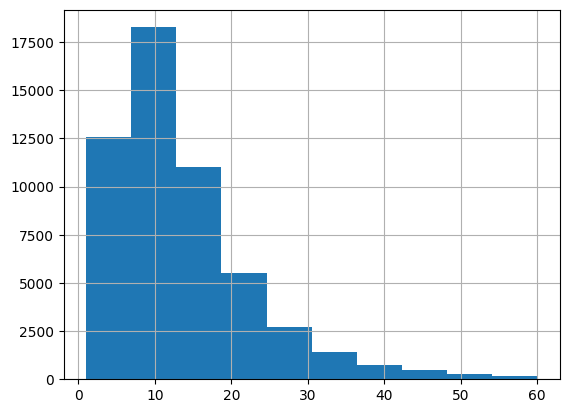

In [11]:
jan_data.duration_min.hist() 

In [12]:
#data splitting
train_data = jan_data.loc[:30000]
val_data = jan_data.loc[30000:]

In [13]:
#model training
model = LinearRegression()
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [14]:
#predictions generation
train_preds = model.predict(train_data[num_features + cat_features])
val_preds = model.predict(val_data[num_features + cat_features])

In [15]:
#scoring
print(mean_absolute_error(train_data[target], train_preds))
print(mean_absolute_error(val_data[target], val_preds))

3.192216438447116
3.444125000798275


In [16]:
#scoring
print(mean_absolute_percentage_error(train_data[target], train_preds))
print(mean_absolute_percentage_error(val_data[target], val_preds))

0.3632942049617662
0.33879786906007886


## Dump model and reference data

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [18]:
val_data['prediction'] = val_preds
train_data['prediction'] = train_preds

In [19]:
val_data.to_parquet('data/reference.parquet')

## Draft Evidently Dashboard for monitoring

In [20]:
ref_data = pd.read_parquet('data/reference.parquet')
#ref_data.set_index('lpep_pickup_datetime', inplace=True)

In [21]:
ref_data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration_min,prediction
30000,2,2022-01-17 17:15:43,2022-01-17 17:26:15,N,5.0,7,138,1.0,3.86,15.0,...,0.00,0.0,None,0.3,15.30,2.0,2.0,0.00,10.533333,15.370173
30001,2,2022-01-17 17:41:39,2022-01-17 17:48:10,N,1.0,41,75,1.0,1.19,6.5,...,1.66,0.0,None,0.3,9.96,1.0,1.0,0.00,6.516667,8.449551
30003,1,2022-01-17 17:44:42,2022-01-17 18:15:19,N,1.0,65,55,1.0,0.00,33.2,...,0.00,0.0,None,0.3,34.00,1.0,1.0,0.00,30.616667,28.687912
30004,2,2022-01-17 17:03:02,2022-01-17 17:16:45,N,1.0,74,238,1.0,2.55,11.5,...,3.21,0.0,None,0.3,19.26,1.0,1.0,2.75,13.716667,12.707609
30005,2,2022-01-17 17:47:12,2022-01-17 18:19:29,N,1.0,92,92,1.0,0.75,18.5,...,0.00,0.0,None,0.3,19.30,2.0,1.0,0.00,32.283333,17.495978


In [25]:
column_mapping = ColumnMapping(
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features,
    
)

In [26]:
report = Report(metrics=[
    DatasetMissingValuesMetric(), 
    DatasetDriftMetric(), 
    ColumnDriftMetric(column_name='prediction')
])

In [30]:
report.run(reference_data=ref_data[:1000], 
           current_data=ref_data[100:1000], 
           column_mapping=column_mapping)

In [31]:
report.show()

In [32]:
result = report.as_dict()
result

{'metrics': [{'metric': 'DatasetMissingValuesMetric',
   'result': {'current': {'different_missing_values': {'': 0,
      -inf: 0,
      None: 900,
      inf: 0},
     'number_of_different_missing_values': 1,
     'different_missing_values_by_column': {'VendorID': {'': 0,
       -inf: 0,
       None: 0,
       inf: 0},
      'lpep_pickup_datetime': {'': 0, -inf: 0, None: 0, inf: 0},
      'lpep_dropoff_datetime': {'': 0, -inf: 0, None: 0, inf: 0},
      'store_and_fwd_flag': {'': 0, -inf: 0, None: 0, inf: 0},
      'RatecodeID': {'': 0, -inf: 0, None: 0, inf: 0},
      'PULocationID': {'': 0, -inf: 0, None: 0, inf: 0},
      'DOLocationID': {'': 0, -inf: 0, None: 0, inf: 0},
      'passenger_count': {'': 0, -inf: 0, None: 0, inf: 0},
      'trip_distance': {'': 0, -inf: 0, None: 0, inf: 0},
      'fare_amount': {'': 0, -inf: 0, None: 0, inf: 0},
      'extra': {'': 0, -inf: 0, None: 0, inf: 0},
      'mta_tax': {'': 0, -inf: 0, None: 0, inf: 0},
      'tip_amount': {'': 0, -inf: 0, Non

In [33]:
result['metrics'][1]['result']['number_of_drifted_columns']

0

In [34]:
result['metrics'][0]['result']['current']['share_of_missing_values']

0.045454545454545456

In [35]:
result['metrics'][2]['result']['drift_score']

1.0